In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import zipline
from zipline.api import (
    order_target_percent,
    symbol,
    set_commission,
    set_slippage,
    schedule_function,
    date_rules,
    time_rules,
)

from zipline.errors import SymbolNotFound
from zipline.assets import Equity

from typing import List

from zipline.finance.commission import PerTrade, PerDollar
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage

from datetime import datetime
import pytz
import pandas as pd
import numpy as np

# To generate random numbers
from random import random, seed, randrange

<IPython.core.display.Javascript object>

Import the S&P 500 membership data from Andreas Clenow's [website](https://www.followingthetrend.com/trading-evolved/)::

In [3]:
%%bash
cd /tmp
rm -rf trading_evolved
rm -f trading_evolved.zip

wget -q -O trading_evolved.zip https://dl.dropbox.com/s/tj85sufbsi820ya/Trading%20Evolved.zip?dl=1
unzip -q -d trading_evolved trading_evolved.zip
ls -lah trading_evolved/data/index_members

total 7.5M
drwxr-xr-x 2 root root 4.0K Jul 15  2019 .
drwxr-xr-x 3 root root 4.0K Aug  7  2019 ..
-rw-r--r-- 1 root root 7.5M May 22  2019 sp500.csv


<IPython.core.display.Javascript object>

In [4]:
DATA_FOLDER = "/tmp/trading_evolved/data/index_members"

<IPython.core.display.Javascript object>

In [5]:
"""
Settings
"""
number_of_runs = 10
random_portfolio_size = False
number_of_stocks = 50  # portfolio size, if not random
sizing_method = "equal"  # equal or random

enable_commission = False
commission_pct = 0.001
enable_slippage = False
slippage_volume_limit = 0.25
slippage_impact = 0.05

<IPython.core.display.Javascript object>

In [6]:
def initialize(context):
    # Fetch and store index membership
    context.index_members = pd.read_csv(
        f"{DATA_FOLDER}/sp500.csv", index_col=0, parse_dates=[0]
    )

    # Set commission and slippage.
    if enable_commission:
        comm_model = PerDollar(cost=commission_pct)
    else:
        comm_model = PerDollar(cost=0.0)
    set_commission(comm_model)

    if enable_slippage:
        slippage_model = VolumeShareSlippage(
            volume_limit=slippage_volume_limit, price_impact=slippage_impact
        )

    else:
        slippage_model = FixedSlippage(spread=0.0)
    set_slippage(slippage_model)

    schedule_function(
        func=rebalance,
        date_rule=date_rules.month_start(),
        time_rule=time_rules.market_open(),
    )

<IPython.core.display.Javascript object>

In [7]:
# In case the bundle we are using have some members in the S&P 500
# index that are missing
def adjust_trading_universe(universe: List[str]) -> List[Equity]:
    new_universe = []
    for market in universe:
        try:
            new_universe.append(symbol(market))
        except SymbolNotFound:
            pass

    return new_universe

<IPython.core.display.Javascript object>

In [8]:
def rebalance(context, data):
    today = zipline.api.get_datetime()

    # Check eligible stocks
    #     todays_universe = [
    #         symbol(ticker)
    #         for ticker in context.index_members.loc[context.index_members.index < today]
    #         .iloc[-1, 0]
    #         .split(",")
    #     ]

    todays_universe = adjust_trading_universe(
        context.index_members.loc[context.index_members.index < today]
        .iloc[-1, 0]
        .split(",")
    )
    # print(f"There are {len((todays_universe))} stocks in today's universe ({today})")

    # Make a list of stocks to buy
    buys = []

    # To modify global variable, and not make new one
    global number_of_stocks

    # If random stockss selected
    if random_portfolio_size:
        # Buy between 5 and 200 stocks.
        number_of_stocks = randrange(5, 200)

    # Select stocks
    for i in np.arange(1, number_of_stocks + 1):
        num = randrange(0, len(todays_universe) - 1)
        buys.append(todays_universe.pop(num))

    # Sell positions no longer wanted.
    for security in context.portfolio.positions:
        if security not in buys:
            order_target_percent(security, 0.0)

    # Make an empty DataFrame to hold target position sizes
    buy_size = pd.DataFrame(index=buys)

    # Get random sizes, if enabled.
    if sizing_method == "random":
        buy_size["rand"] = [randrange(1, 100) for x in buy_size.iterrows()]
        buy_size["target_weight"] = buy_size["rand"] / buy_size["rand"].sum()
    elif sizing_method == "equal":
        buy_size["target_weight"] = 1.0 / number_of_stocks

    # Send buy orders
    for security in buys:
        order_target_percent(security, buy_size.loc[security, "target_weight"])

<IPython.core.display.Javascript object>

In [9]:
# start = pd.Timestamp("1996-01-01", tz="utc")
start = pd.Timestamp("2018-01-01", tz="utc")
end = pd.Timestamp("2018-12-31", tz="utc")

<IPython.core.display.Javascript object>

In [10]:
# Empty DataFrame to hold the results
df = pd.DataFrame()

<IPython.core.display.Javascript object>

In [11]:
%%time
# Run the backtests
for i in np.arange(1, number_of_runs + 1):
    print("Processing run " + str(i))

    result = zipline.run_algorithm(
        start=start,
        end=end,
        initialize=initialize,
        capital_base=100000,
        data_frequency="daily",
        bundle="random_stocks",
    )  # book uses ac_equities_db, quandl is broken apparently because it does not store all the tickers that make up the S&P 500

    df[i] = result["portfolio_value"]

print("All Done. Ready to analyze.")

Processing run 1


/usr/local/lib/python3.6/site-packages/empyrical/stats.py:799: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


Processing run 2
Processing run 3
Processing run 4


KeyboardInterrupt: 

<IPython.core.display.Javascript object>

/usr/local/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)


<AxesSubplot:>

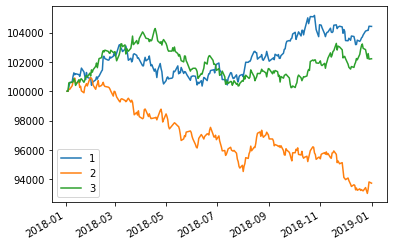

<IPython.core.display.Javascript object>

In [12]:
df.plot()